# CIFAR-10 の CNN でのバイナリ化検討

CIFAR-10 の CNNを利用して、入力のバイナリ化による影響を評価し、完全なバイナリネット(Fully Binary Network) の可能性を探る

## はじめに
一般的にネットワークのバイナリ化といっても、初段の層は多値で入力することが多い。
一方で当サイトが進めるLUT-Netなどは時間方向へのバイナリ変調など含めて当初からすべてフルバイナリで検証を行ってきた。
またここにきて時間方向への変調だけでなく、チャネル方向(Depth方向)への変調含めて効果が出てきた。
一方で従来の「初段の層は多値で入力する」やり方とのベンチマークができていなかった。
そこで、パラメータを変えたいくつかの実験を行ったのでそのログをグラフ化してベンチマークを行う

「初段の層は多値で入力する」場合、初段の層の出力が32チャンネルの3x3Convだとして、3x3x3x32=864個の乗算器が必要となる。これはハードウェア化する場合に大きなインパクトである。
多くのバイナリネットワークは2層目以降で1bit演算(つまり1ゲート)で1接続を賄うため、非常に回路をコンパクトにできる。これを初段から適用する場合の可能性について参考データとしたい。

In [27]:
## 読み込みコード

In [28]:
import numpy as np
import re
import matplotlib.pyplot as plt

In [29]:
def read_log_file(fname):
    '''ログファイルを読み込む'''
    ptn = r'.*test accuracy : ([0-9]+\.?[0-9]*).*test loss : ([0-9]+\.?[0-9]*).*train accuracy : ([0-9]+\.?[0-9]*).*train loss : ([0-9]+\.?[0-9]*).*'
    result_list = []
    with open(fname, 'r') as f:
        for line in f:
            m = re.match(ptn, line)
            if m:
                g = m.groups()
                result_list.append([float(g[0]), float(g[1]), float(g[2]), float(g[3])])
    return np.array(result_list)

In [30]:
def draw_graph(log_data, filename=None):
    '''グラフ化する'''
    plt.figure(figsize=(16, 10))
    
    plt.subplot(221)
    for key in log_data:
        plt.plot(log_data[key][:,0], label=key)
    plt.legend()
    plt.ylim(0, 1)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('test accuracy')

    plt.subplot(222)
    for key in log_data:
        plt.plot(log_data[key][:,1], label=key)
    plt.ylim(0, 4)
    plt.legend()
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('test loss')

    plt.subplot(223)
    for key in log_data:
        plt.plot(log_data[key][:,2], label=key)
    plt.legend()
    plt.ylim(0, 1)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('train accuracy')

    plt.subplot(224)
    for key in log_data:
        plt.plot(log_data[key][:,3], label=key)
    plt.legend()
    plt.ylim(0, 4)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('train loss')
    
    if filename:
        plt.savefig(filename)
    plt.show()

## bit数削減影響

まず初めに普通にすべて FP32 で演算する普通のCNN にて、8bitの画像データ入力(3色256階調)をMSB 4bitだけ残るようにマスクした場合(3色16階調)の量子化影響を見ておく

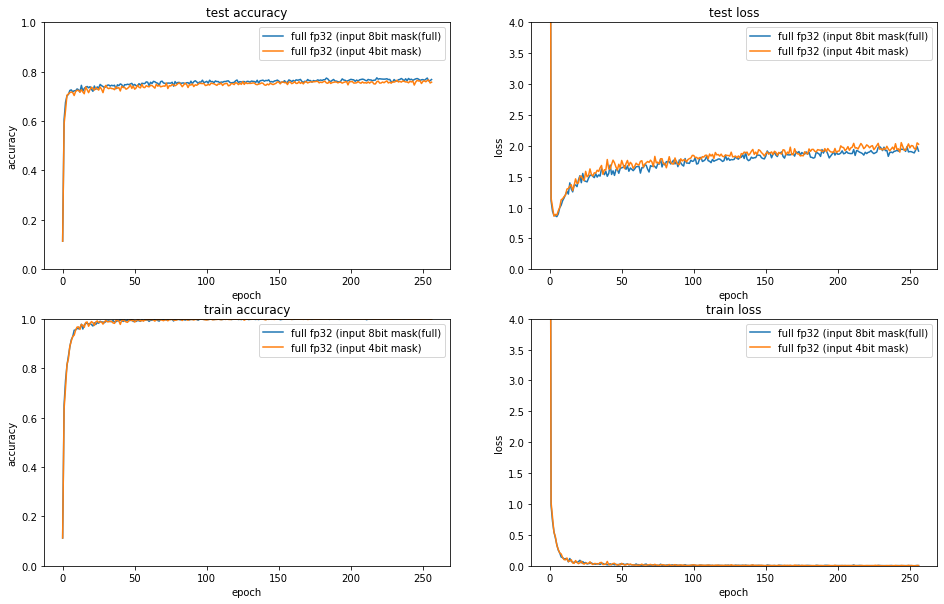

In [33]:
# bit削減影響
log_data = {}
log_data['full fp32 (input 8bit mask(full)']  = read_log_file('Cifar10BinarizeTest_fp32_log.txt')
log_data['full fp32 (input 4bit mask)']       = read_log_file('Cifar10BinarizeTest_fp32_bit4_log.txt')
draw_graph(log_data, 'CIFAR-10_fully-binary_CNN_evaluation_bit_mask.png')

グラフから上位4bitあれば劣化は十分少ないと考えられる。

## ネットワークのバイナリ化影響

次に従来のネットワーク化に倣い、初段の層の入力FP32としてのReLU層をすべてBinarize層に置き換えてネットワークのバイナリ化による劣化を確認しておく。

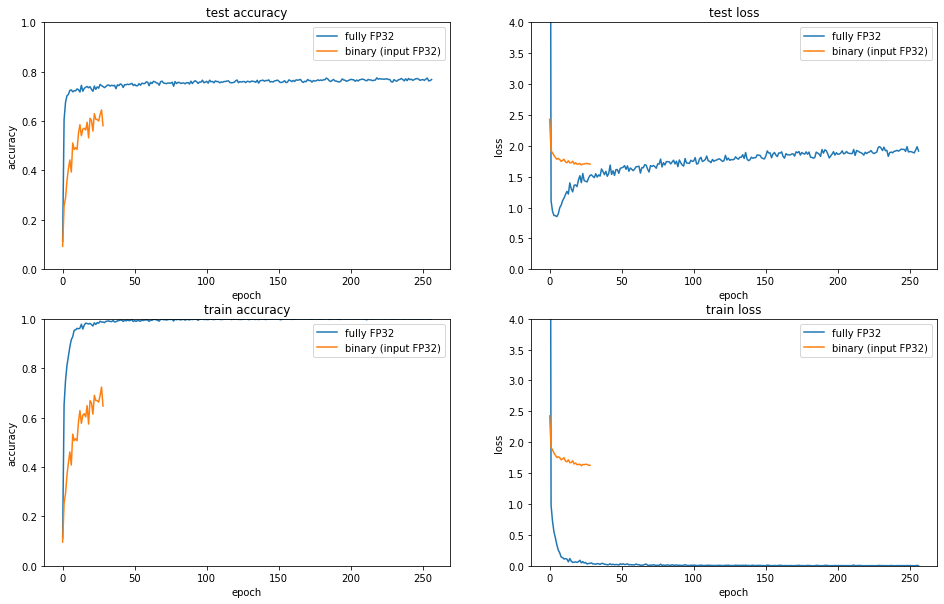

In [37]:
log_data = {}
log_data['fully FP32']           = read_log_file('Cifar10BinarizeTest_fp32_log.txt')
log_data['binary (input FP32)']  = read_log_file('Cifar10BinarizeTest_depth=0_frame=0_log.txt')
draw_graph(log_data, 'CIFAR-10_fully-binary_CNN_evaluation_quantize.png')

まだ計算中だが結構劣化しそう...

## 時間方向のバイナリ変調
ここから Fully Binary ネットワークの実験として、入力から完全バイナリ化する。
その際、一番最初にやった方法として、バイナリ化の閾値を変調する方法である。
同じ画像フレームに対して異なる閾値で作った二値化画像フレームを同じネットワークに通して結果を平均化することで精度向上を図る。この方法の利点はバイナリネットワーク自体は１個であり回路規模が小さいことと、出力も多値で得られることである。
デメリットは何度もforward演算を行う必要があることである。
原理的に音声信号など1次元データで用いられる 1bit ADC のバイナリ変調に近いものと考えており、高速度カメラなどを用いてオーバーサンプリングを行うことで、階調方向の分解能を時間方向に拡散させる(そういう意味ではディザの一種)事も可能と考えており、よりリアルタイム性の高いアプリケーションで効果を発揮する可能性がある。

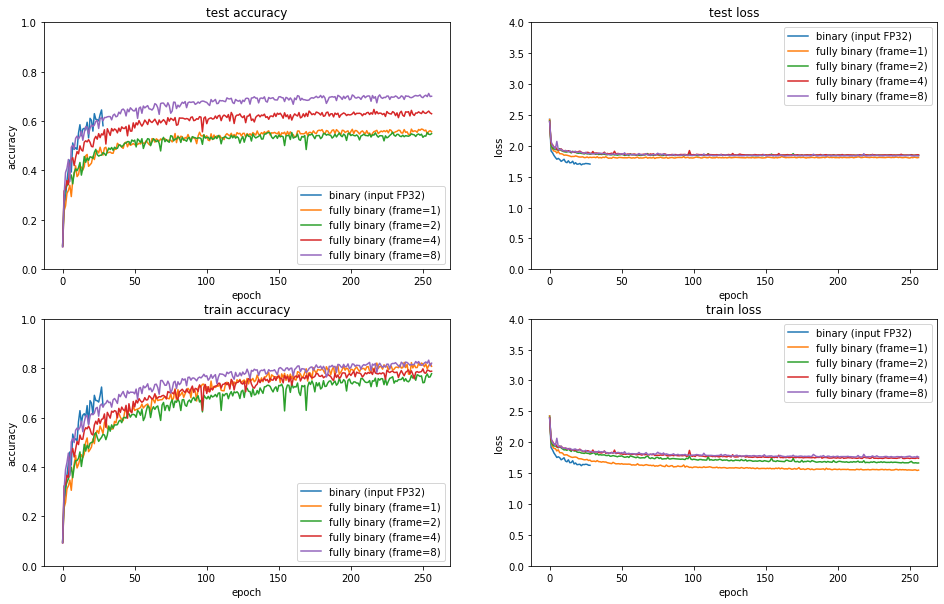

In [41]:
# frame変化
log_data = {}
log_data['binary (input FP32)']     = read_log_file('Cifar10BinarizeTest_depth=0_frame=0_log.txt')
log_data['fully binary (frame=1)']  = read_log_file('Cifar10BinarizeTest_depth=1_frame=1_log.txt')
log_data['fully binary (frame=2)']  = read_log_file('Cifar10BinarizeTest_depth=1_frame=2_log.txt')
log_data['fully binary (frame=4)']  = read_log_file('Cifar10BinarizeTest_depth=1_frame=4_log.txt')
log_data['fully binary (frame=8)']  = read_log_file('Cifar10BinarizeTest_depth=1_frame=8_log.txt')
draw_graph(log_data, 'CIFAR-10_fully-binary_CNN_evaluation_frame_modulation.png')

フレーム数を増やしていくと精度が向上していくことがわかる。
閾値の違うものを同じ回路に入れて再集計するだけで精度が上がるという点は非常に興味深い。
(ベンチマーク対象はまだ計算中である)

## チャネル方向(depth方向)への変調

従来の入力はRGB 3チャネルのFP32を特定の閾値で2値化して、3チャネルのバイナリ入力としていた。
ここで、異なる閾値で二値化することによってdepth方向に情報を拡散させる実験を行った。
例えば、depth=4 では、閾値を4段階用意して、12チャネルのバイナリ入力としている。
これは MSB 2bit 分の情報を入力することになるが、6入力LUTなどを備えるFPGAなどでは、素子1個で6bitまでの2値化は行えるため、殆どリソース消費せずにこの入力を作ることができる。
また２層目以降は32チャンネルや64チャネルの層を構成するため1層目がその水準に増えたからと言って全体のインパクトは大きくは変わらないと考える。
したがってこの方法がうまくいくと、非常に低遅延で高い性能が出せるバイナリネットワークが構成可能となる。

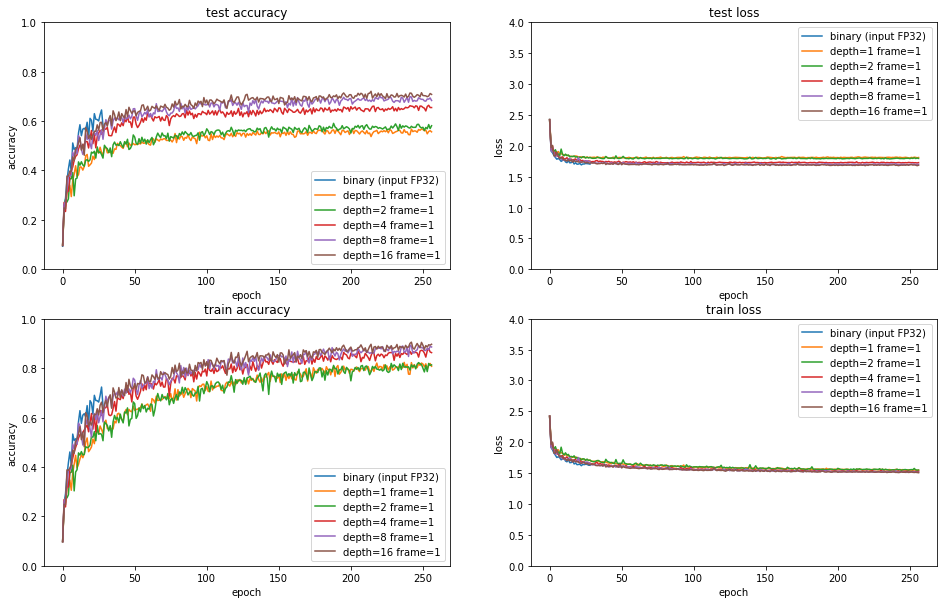

In [43]:
# depth変化
log_data = {}
log_data['binary (input FP32)']     = read_log_file('Cifar10BinarizeTest_depth=0_frame=0_log.txt')
log_data['depth=1 frame=1']  = read_log_file('Cifar10BinarizeTest_depth=1_frame=1_log.txt')
log_data['depth=2 frame=1']  = read_log_file('Cifar10BinarizeTest_depth=2_frame=1_log.txt')
log_data['depth=4 frame=1']  = read_log_file('Cifar10BinarizeTest_depth=4_frame=1_log.txt')
log_data['depth=8 frame=1']  = read_log_file('Cifar10BinarizeTest_depth=8_frame=1_log.txt')
log_data['depth=16 frame=1'] = read_log_file('Cifar10BinarizeTest_depth=16_frame=1_log.txt')
draw_graph(log_data, 'CIFAR-10_fully-binary_CNN_evaluation_depth_modulation.png')

Depth数を増やしていくと精度が向上していくことがわかる。
(ベンチマーク対象はまだ計算中である)

## frame変調とdepth変調のハイブリッド

frame変調とdepth変調は共存可能である。
具体的には depth 変調の閾値を、さらに frame変調で変化させる。

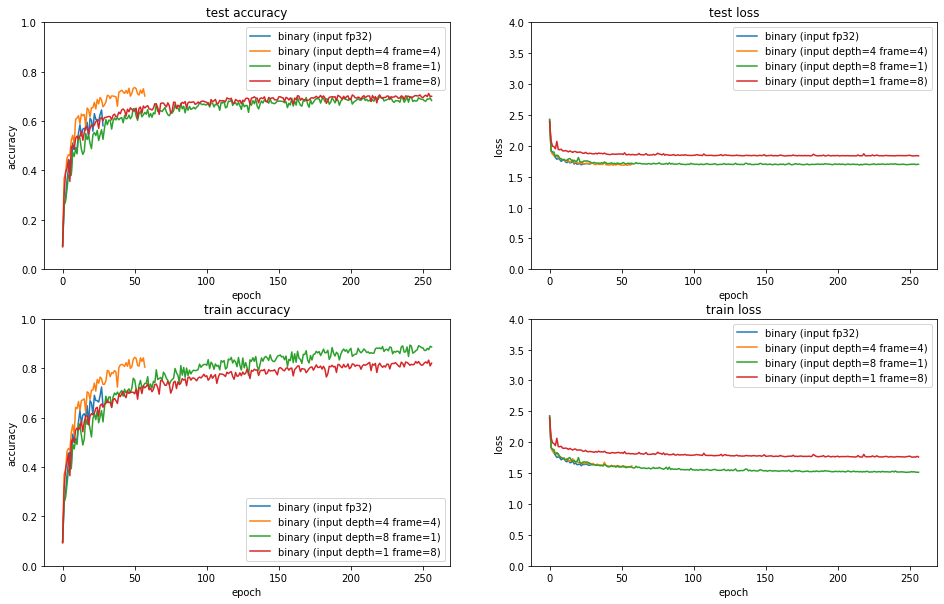

In [46]:
log_data = {}
log_data['binary (input fp32)']             = read_log_file('Cifar10BinarizeTest_depth=0_frame=0_log.txt')
log_data['binary (input depth=4 frame=4)']  = read_log_file('Cifar10BinarizeTest_depth=4_frame=4_log.txt')
log_data['binary (input depth=8 frame=1)']  = read_log_file('Cifar10BinarizeTest_depth=8_frame=1_log.txt')
log_data['binary (input depth=1 frame=8)']  = read_log_file('Cifar10BinarizeTest_depth=1_frame=8_log.txt')
draw_graph(log_data, 'CIFAR-10_fully-binary_CNN_evaluation_frame_depth_modulation.png')

(これもまだ計算中だが、期待できそうな進行をしている)